In [2]:
import os, sys
os.chdir(os.path.abspath('..'))

In [3]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [4]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib

In [5]:
config_dir = 'config_files/'
config_file = 'config0.json'
with open(config_dir + config_file, 'r') as f: config = json.load(f)

In [32]:
config["data"]["subsample_rate"]["user"] = 100
config["data"]["condition_tag_list"] = ["months", "weekdays", "day_befores"]
config["data"]["ampute_params"]["b"] = 5

In [33]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=5
Mean of enrolments: 53.03
Number of Training Points...............12414
Number of Testing Points.................5037
Number of Validation Points..............4063
Number of Missing Points.................3671


In [34]:
class ForecastingFCN(nn.Module):
    def __init__(self, input_size=1, context_size=0, hidden_size=64, num_hidden_layers=2, forecast_horizon=1):
        """
        Args:
            input_size (int): Size of the time-series input (default is 1 for one-dimensional time-series).
            context_size (int): Size of the contextual information vector.
            hidden_size (int): Number of hidden units in each hidden layer.
            num_hidden_layers (int): Number of fully connected hidden layers.
            forecast_horizon (int): Number of timesteps to forecast.
        """
        super(ForecastingFCN, self).__init__()
        
        # Define a simple fully connected network
        self.input_layer = nn.Linear(input_size + context_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_size, forecast_horizon)
        self.relu = nn.ReLU()
    
    def forward(self, time_series, context):
        """
        Args:
            time_series (torch.Tensor): Input time series tensor of shape (batch_size, T, input_size).
            context (torch.Tensor): Contextual information tensor of shape (batch_size, context_size).
        
        Returns:
            torch.Tensor: Forecasted values of shape (batch_size, forecast_horizon).
        """
        # Flatten the time series along the time dimension
        batch_size = time_series.shape[0]
        flattened_time_series = time_series.view(batch_size, -1)
        
        # Concatenate flattened time series and context
        x = torch.cat((flattened_time_series, context), dim=-1)
        
        # Forward pass through input layer
        x = self.relu(self.input_layer(x))
        
        # Forward pass through hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.relu(hidden_layer(x))
        
        # Forward pass through output layer to generate the forecast
        forecast = self.output_layer(x)
        
        return forecast


In [35]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [47]:
# Hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001
hidden_size = 1000
num_layers = 2
forecast_horizon = 24  # Change this to the desired number of forecast steps

In [48]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Assuming trainset and valset are instances of ConditionedDataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model, Loss Function, and Optimizer
input_size = 24  # Assuming one-dimensional time-series
context_size = trainset[0][1].shape[0]  # Get size of contextual information from the dataset
model = ForecastingFCN(input_size=input_size, context_size=context_size-input_size, hidden_size=hidden_size, 
                        num_hidden_layers=num_layers, forecast_horizon=forecast_horizon).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop with Validation
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode
    
    # Training phase
    for batch_inputs, batch_conditions in train_loader:
        # Move inputs and conditions to the selected device
        batch_inputs, batch_conditions = batch_inputs.to(device), batch_conditions.to(device)

        day_before = batch_conditions[:, -24:]
        batch_conditions = batch_conditions[:, :-24]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(day_before, batch_conditions)
        
        # Compute loss
        loss = criterion(outputs, batch_inputs.squeeze())  # Compare with the last 'forecast_horizon' steps
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_conditions in val_loader:
            # Move validation inputs and conditions to the selected device
            val_inputs, val_conditions = val_inputs.to(device), val_conditions.to(device)

            day_before = val_conditions[:, -24:]
            val_conditions = val_conditions[:, :-24]

            # Forward pass
            val_outputs = model(day_before, val_conditions)
            
            # Compute validation loss
            loss = criterion(val_outputs, val_inputs.squeeze())
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")


Epoch 1/50, Training Loss: 0.4696, Validation Loss: 0.4270
Epoch 2/50, Training Loss: 0.4107, Validation Loss: 0.3862
Epoch 3/50, Training Loss: 0.3910, Validation Loss: 0.3751
Epoch 4/50, Training Loss: 0.3754, Validation Loss: 0.3828
Epoch 5/50, Training Loss: 0.3639, Validation Loss: 0.3759
Epoch 6/50, Training Loss: 0.3529, Validation Loss: 0.3689
Epoch 7/50, Training Loss: 0.3419, Validation Loss: 0.3732
Epoch 8/50, Training Loss: 0.3289, Validation Loss: 0.3860
Epoch 9/50, Training Loss: 0.3163, Validation Loss: 0.3727
Epoch 10/50, Training Loss: 0.3046, Validation Loss: 0.3703
Epoch 11/50, Training Loss: 0.2887, Validation Loss: 0.3804
Epoch 12/50, Training Loss: 0.2752, Validation Loss: 0.3825
Epoch 13/50, Training Loss: 0.2614, Validation Loss: 0.3903
Epoch 14/50, Training Loss: 0.2484, Validation Loss: 0.3998
Epoch 15/50, Training Loss: 0.2342, Validation Loss: 0.3850
Epoch 16/50, Training Loss: 0.2209, Validation Loss: 0.3894
Epoch 17/50, Training Loss: 0.2043, Validation Lo

KeyboardInterrupt: 

In [49]:
conditions_test = torch.tensor(conditioner.transform(condition_set["test"])).float().to(device)
day_befores = conditions_test[:, -24:]
conditions_test = conditions_test[:, :-24]

In [50]:
test_estimates = model(day_befores, conditions_test)
test_estimates = test_estimates.reshape(69,-1,24).cpu().detach().numpy()

In [51]:
X_test_user = X_test.reshape(69,-1,24)

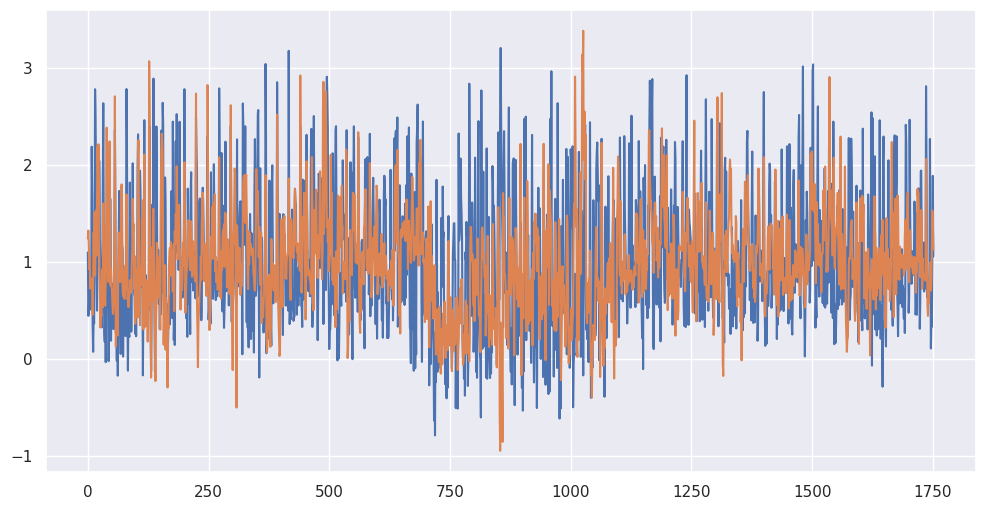

In [52]:
user_id = 5
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(X_test_user[user_id].flatten(), label="True")
plt.plot(test_estimates[user_id].flatten(), label="Forecast")